### Import modules

In [1]:
import pandas as pd
import numpy as np

from diamondminer.miner import *
from diamondminer import utils

%matplotlib inline

#use the following command to implement changes to the repository locally: pip install --user .

### Load Data

First you need to load your data; here is an example demo dataset.

> Note: Data is assumed to be clean and cropped so that it zooms into diamonds of interest.

### Take the log of the data (just testing)

In [7]:
import numpy as np

def process_file(input_file, output_file):
    # Read the input file
    with open(input_file, 'r') as f:
        lines = f.readlines()

    # Extract voltage values and current data
    voltages_row = np.array([float(v) for v in lines[0].split()])
    data = []
    voltages_col = []

    for line in lines[1:]:
        values = line.split()
        voltages_col.append(float(values[0]))
        data.append([float(x) for x in values[1:]])

    voltages_col = np.array(voltages_col)
    data = np.array(data)

    # Calculate the logarithm of the data
    # Adding a small constant to avoid log(0)
    log_data = np.log10(np.abs(data) + 1e-20)

    # Write the output file
    with open(output_file, 'w') as f:
        # Write the voltage row
        f.write('\t'.join(f'{v:.6e}' for v in voltages_row) + '\n')

        # Write the logarithm data
        for i, v in enumerate(voltages_col):
            row = [v] + list(log_data[i])
            # Format the first column without scientific notation, rest with scientific notation
            formatted_row = f'{v:.6f}\t' + '\t'.join(f'{x:.6e}' for x in row[1:])
            f.write(formatted_row + '\n')

    print(f"Logarithm data has been written to {output_file}")

# Usage
input_file = 'demo_data_1.txt'  # Replace with your input file name
output_file = 'log_output.txt'  # Replace with your desired output file name

process_file(input_file, output_file)

Logarithm data has been written to log_output.txt


### Plot the Data

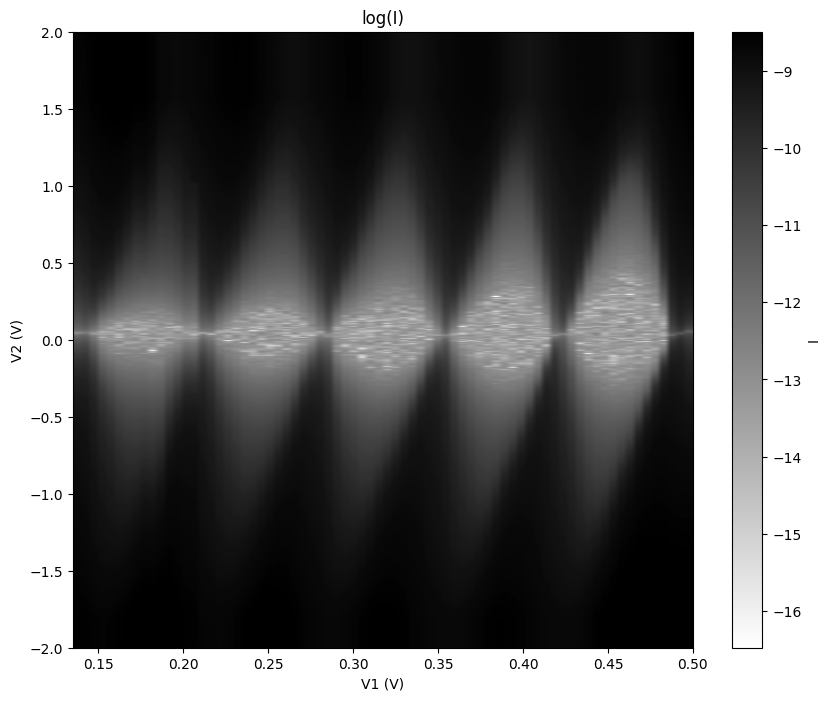

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    V1 = np.array(lines[0].split()).astype(float)
    data = []
    V2 = []
    
    for line in lines[1:]:
        values = line.split()
        V2.append(float(values[0]))
        data.append([float(x) for x in values[1:]])
    
    V2 = np.array(V2)
    data = np.array(data)
    
    return V1, V2, data

def plot_2d_color(V1, V2, data, filename):
    plt.figure(figsize=(10, 8))
    plt.imshow(data, extent=[V1.min(), V1.max(), V2.min(), V2.max()], 
               aspect='auto', origin='lower', cmap='binary')
    # plt.colorbar(label='dI/dV2')
    plt.colorbar(label='I')
    plt.xlabel('V1 (V)')
    plt.ylabel('V2 (V)')
    # plt.title('2D Color Plot of dI/dV2')
    plt.title('log(I)')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
# input_file = 'derivative_output.txt'
input_file = 'log_output.txt'
output_file = 'dIdV2_color_plot.png'

V1, V2, data = read_data(input_file)
plot_2d_color(V1, V2, data, output_file)

### Plot experimental CSV data

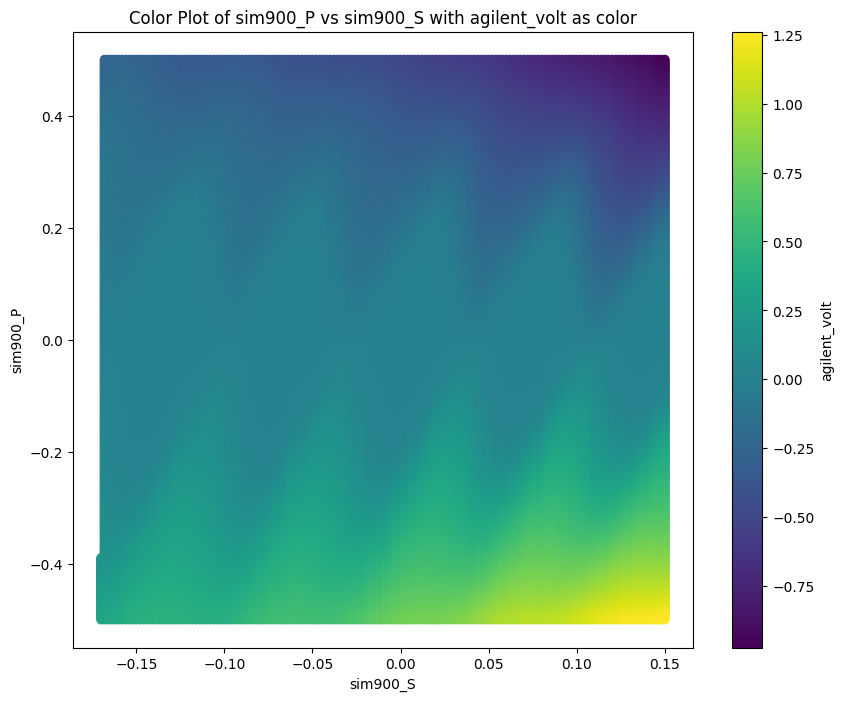

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('results-1-34 copy.csv')

# Create the color plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['sim900_P'], df['sim900_S'], c=df['agilent_volt'], cmap='viridis')

# Add colorbar
plt.colorbar(scatter, label='agilent_volt')

# Set labels and title
plt.xlabel('sim900_S')
plt.ylabel('sim900_P')
plt.title('Color Plot of sim900_P vs sim900_S with agilent_volt as color')

# Show the plot
plt.show()

### Load experimental CSV data

In [5]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('results-1-34 Copy.csv')

# Extract unique values for sim900_P and sim900_S
P_data = df['sim900_P'].unique().astype(float)
S_data = df['sim900_S'].unique().astype(float)

# Create a pivot table with sim900_P as columns, sim900_S as index, and agilent_volt as values
pivot_table = df.pivot(index='sim900_S', columns='sim900_P', values='agilent_volt')

# Convert the pivot table to a numpy array
I_data = pivot_table.to_numpy().astype(float)

# Ensure P_data and S_data are in the correct order
P_data.sort()
S_data.sort()

# Print the shapes to verify
print("P_data shape:", P_data.shape)
print("S_data shape:", S_data.shape)
print("I_data shape:", I_data.shape)

P_data shape: (161,)
S_data shape: (501,)
I_data shape: (501, 161)


### Load & plot the diamonds26 Data

P_data shape: (250,)
S_data shape: (501,)
I_data shape: (501, 250)


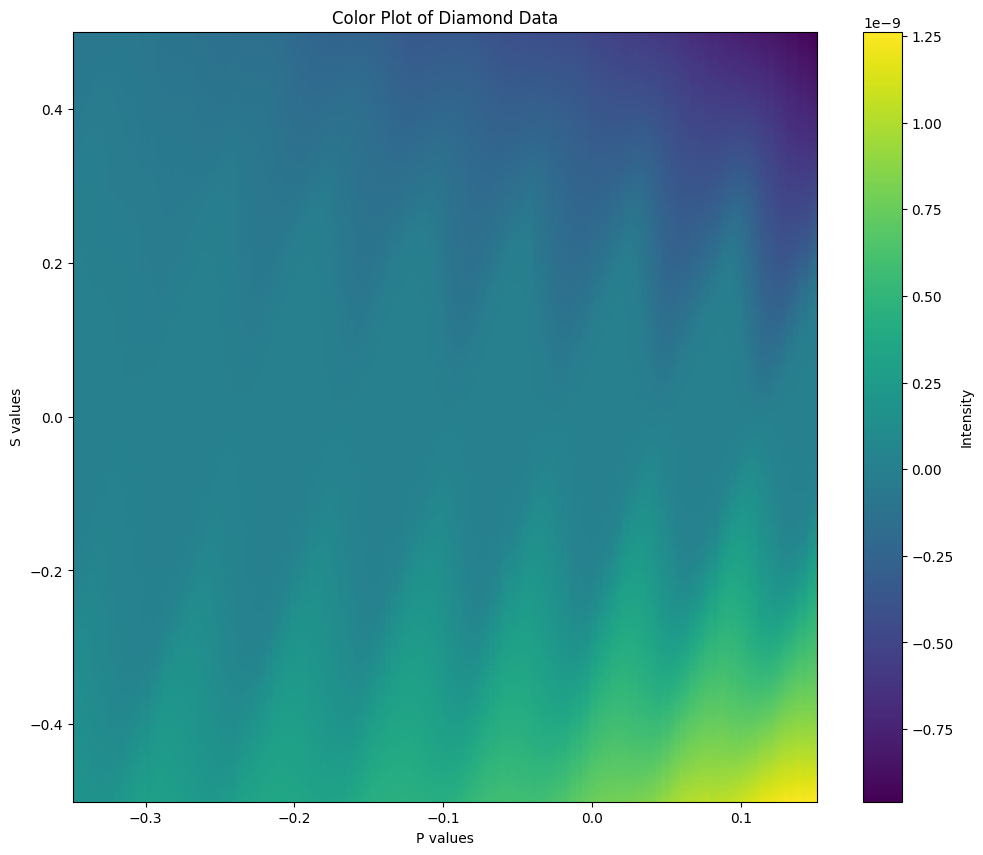

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data, specifying the columns to use
data = np.loadtxt('diamonds26.txt', usecols=range(251))  # Use the first 251 columns

# Extract P_data, S_data, and I_data
P_data = data[0, 1:]  # First row, excluding the first element
S_data = data[1:, 0]  # First column, excluding the first element
I_data = data[1:, 1:]  # Rest of the data (2D array)

# Ensure the data is in float format
P_data = P_data.astype(float)
S_data = S_data.astype(float)
I_data = I_data.astype(float)

# Print the shapes to verify
print("P_data shape:", P_data.shape)
print("S_data shape:", S_data.shape)
print("I_data shape:", I_data.shape)

# Create the color plot
plt.figure(figsize=(12, 10))
plt.pcolormesh(P_data, S_data, I_data, shading='auto', cmap='viridis')
plt.colorbar(label='Intensity')

# Set labels and title
plt.xlabel('P values')
plt.ylabel('S values')
plt.title('Color Plot of Diamond Data')

# Show the plot
plt.show()

### Load the OG Data

In [2]:
# Load the data from the txt file
demo_data_loaded = pd.read_csv('demo_data_1.txt', sep='\t', index_col=0)
# demo_data_loaded = pd.read_csv('results-1-34.csv', sep=',', index_col=0)



# Convert the loaded data back to numpy arrays if needed
P_data = demo_data_loaded.columns.to_numpy().astype(float)
S_data = demo_data_loaded.index.to_numpy().astype(float)
I_data = demo_data_loaded.to_numpy().astype(float)

#### *Optional*: Load from QCoDeS Database

You may want to load from a qcodes database,
```python
db_file = "path/to/qcodes.db"
P_data, S_data, I_data = utils.get_data_from_qcodes_db(
    path_to_db=db_file,
    run_id=41,
    exp_name="exp-name"
)
```

### Extract Diamonds

Next step is to extract the diamonds found in your data. The program does this by,

1. Breaking the data into two halfs: upper and lower.
2. Each half is used as input to the Hough transform.
3. Detected lines are then filtered for any duplicates and are sorted based on which section they belong
and whether their slope is positive or negative.
4. Finally, cluster the relevent lines together and "glue" them together to form our diamonds.

> Note: If the extraction isn't working, turn `debug=True` to plot any intermediate results. 
Adjust parameters found in `miner.filter_raw_data()`, `miner.extract_edges()`, `miner.extract_lines()` until lines are detected.

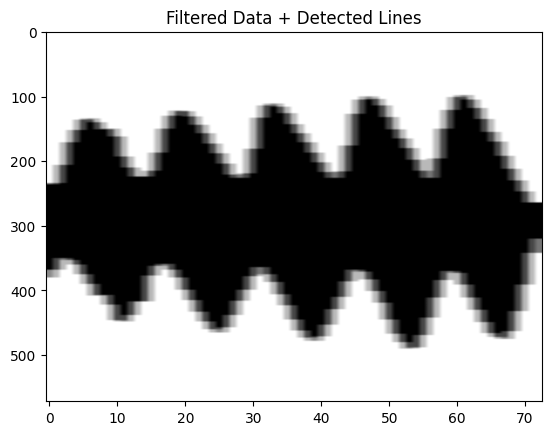

C:\Users\alisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\diamondminer\miner.py:184: RuntimeWarning: divide by zero encountered in log
  filtered_current_data = np.log(


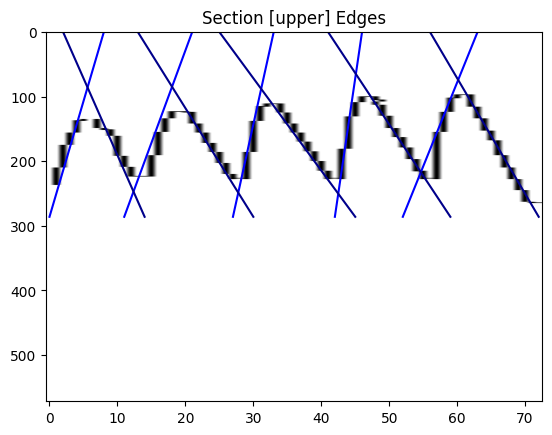

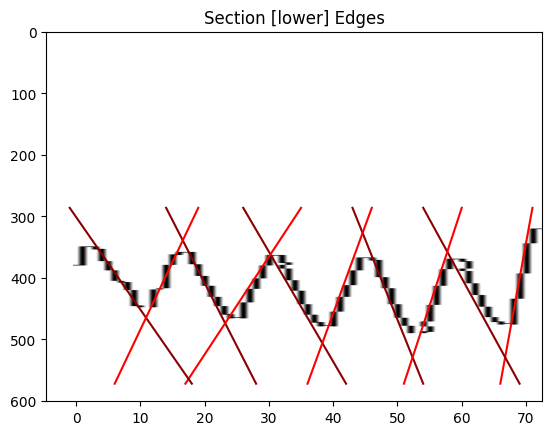

In [3]:
device_voltage_conversion = 1e-2 # Data might have voltage divider connect to source on device
current_sensitivity = 1 # If your data is in volts need to convert using sensitivity

# Can crop by index if desired to isolate diamonds of interest
crop_left = 0 
crop_right = -1

miner = Miner(
    gate_data=P_data[crop_left:crop_right], # Volts
    ohmic_data=S_data[:] * device_voltage_conversion, # Volts
    current_data=I_data[:, crop_left:crop_right] * current_sensitivity, # Ampheres
    # Material properties below are OPTIONAL!
    # They allow for the estimation of dot radius.
    epsR = 6.13, # SiO2
    oxide_thickness = 15e-9, #nm,
    # epsR = 3.7, # SiO2
    # oxide_thickness = 10e-9, #nm,
    # epsR = 11.7, #Si
    # Tunables for pre-filtering the data
    binary_threshold=1.1, # > 1
    blur_sigma=1.,
    blur_kernel=(3,3),
)
diamonds = miner.extract_diamonds(debug = True)

### Plotting the results!

Summary (#0):


Constants
---------
Elementary Charge (e): 1.60218e-19 C
Permittivity of Free Space (ϵ0): 8.85419e-12 F/m
Relative Permittivity (ϵR): 6.13000
Oxide Thickness: 15.00000 nm
---------


Geometry
---------
Left Vertex: [0.135 0.   ]
Top Vertex: [0.18431507 0.01244755]
Right Vertex: [0.2040411 0.       ]
Bottom Vertex: [ 0.15965753 -0.01405594]
Width: 69.04110 mV
Height: 26.50350 mV
---------


Dot Properties
--------------
Total Lever Arm (α): 0.19194 eV/V
Drain Lever Arm (β): 0.28455 eV/V
Source Lever Arm (γ): 0.60053 eV/V
Addition Voltage: 69.04110 mV
Charging Voltage: 13.25175 mV
Gate Capacitance: 2.32061 aF
Source Capacitance: 3.86425 aF
Drain Capacitance: 5.83475 aF
Total Capacitance: 12.09030 aF
Dot Radius: 32.61255 nm
--------------


Summary (#1):


Constants
---------
Elementary Charge (e): 1.60218e-19 C
Permittivity of Free Space (ϵ0): 8.85419e-12 F/m
Relative Permittivity (ϵR): 6.13000
Oxide Thickness: 15.00000 nm
---------


Geometry
---------
Left Vertex: [0.20

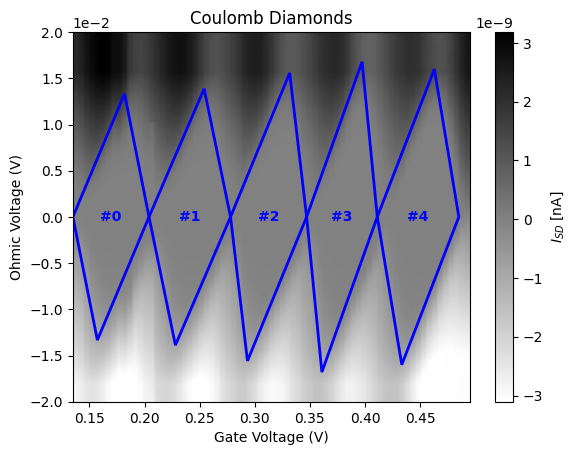

<Figure size 640x480 with 0 Axes>

In [4]:
miner.plot_diamonds()

In [5]:
statistics = miner.get_statistics()

Average Lever Arm (α) : 0.21113 eV/V ± 0.00480 eV/V
Average Addition Voltage: 70.02740 mV ± 0.73808 mV
Average Charging Voltage: 14.72028 mV ± 0.23821 mV
Average Total Capacitance: 10.95567 aF ± 0.17699 aF
Average Gate Capacitance: 2.29443 aF ± 0.02471 aF
Average Source Capacitance: 2.99173 aF ± 0.14664 aF
Average Drain Capacitance: 5.39550 aF ± 0.08000 aF
Average Dot Radius: 31.01920 nm ± 0.25096 nm


### Estimate Charge Temperature

Next step is to extract the temperature of your charges based on data found in the Coulomb diamonds. The program does this by,

1. Slicing the data at a specified user ohmic value, $$\vert V_{SD}\vert \leq 200 \mu V$$
2. Fit the Coulomb oscillation to the theoretical function (see supplemental [here](https://pubs.aip.org/aip/apl/article/120/18/184003/2833621/Wafer-scale-low-disorder-2DEG-in-28Si-SiGe-without)),

$$
I(V_G) = A + B \cosh^{-2}\left(\alpha\frac{V_0 - V}{2 k_B T}\right)
$$

where $A, B, V_0$ and $T$ are fit coefficients and $\alpha$ is the lever arm that comes from the Coulomb diamond data.

3. The average temperature is determined by averaging the results from the $N$ detected Coulomb oscillations,

$$
T = \mu_T \pm \frac{\sigma_T}{\sqrt{N}}
$$

C:\Users\alisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\alisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\alisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value 

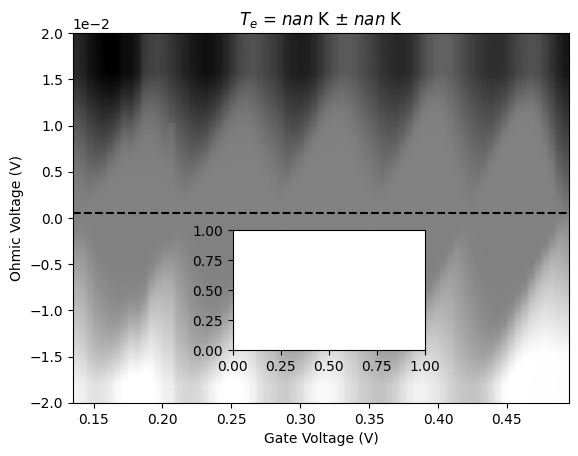

In [11]:
ohmic_value = 500e-6 # Volts

temperatures = miner.estimate_temperatures(
    diamonds, 
    ohmic_value,
    temperature_guess=2
)